In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [6]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "obso"

In [9]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [214]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from datetime import date
from typing import Optional

class LifeCycle(BaseModel):
    product_name: str = Field(..., description="The name of the product.")
    version: Optional[str] = Field(None, description="The version of the product.")
    release_date: str = Field(..., description="The date when the product was first released (YYYY-MM-DD).")
    mainstream_support_end: str = Field(..., description="The date when mainstream support ends (YYYY-MM-DD).")
    extended_support_end: Optional[str] = Field(None, description="The date when extended support ends, if applicable (YYYY-MM-DD).")
    end_of_support: str = Field(..., description="The final date when all support ends (YYYY-MM-DD).")
    end_of_life: str = Field(..., description="The date when the product reaches the end of its lifecycle (YYYY-MM-DD).")
    is_supported: bool = Field(..., description="Indicates if the product is currently supported.")
    replacement_product: Optional[str] = Field(None, description="Suggested replacement product after EOL.")

class ProductDetails(BaseModel):
    product_name: str = Field(..., description="The official name of the product")
    product_number: str = Field(..., description="Unique identifier for the product")
    description: str = Field(..., description="A brief overview of the product's purpose and features")
    manufacturer: str = Field(..., description="Company producing the item")
    product_family: Optional[str] = Field(None, description="The category the product belongs to")
    datasheet_url: Optional[str] = Field(None, description="URL to the product datasheet")
    # Technical specifications
    power_requirements: Optional[str] = Field(None, description="Voltage, current, power consumption, etc.")
    dimensions: Optional[str] = Field(None, description="Size of the product")
    weight: Optional[str] = Field(None, description="Product weight")
    operating_temperature: Optional[str] = Field(None, description="Operating temperature range")
    humidity_range: Optional[str] = Field(None, description="Humidity tolerance")
    ip_rating: Optional[str] = Field(None, description="Ingress Protection (IP) rating")
    performance_metrics: Optional[str] = Field(None, description="Speed, capacity, and other performance data")
    certifications: Optional[str] = Field(None, description="Compliance with standards like CE, RoHS, UL")
    interfaces: Optional[str] = Field(None, description="Available communication interfaces, e.g., Ethernet, RS-485")
    compatibility: Optional[str] = Field(None, description="Compatible devices and software")
    mtbf: Optional[str] = Field(None, description="Mean Time Between Failures (MTBF)")
# Étape 1 : Définition du périmètre
class PerimetreComposant(BaseModel):
    composant: str = Field(..., description="Nom du composant analysé")
    systeme_associe: str = Field(..., description="Système auquel le composant appartient")
    responsable: str = Field(..., description="Personne responsable de l'analyse")
    date_analyse: Optional[date] = Field(None, description="Date de réalisation de l'AMDEC")

# Étape 2 : Identification des modes de défaillance
class ModeDefaillanceComposant(BaseModel):
    mode: str = Field(..., description="Mode de défaillance identifié")
    cause: str = Field(..., description="Cause potentielle de la défaillance")
    effet: str = Field(..., description="Effet de la défaillance sur le système")
    detection_existante: Optional[str] = Field(None, description="Moyen de détection existant")

# Étape 3 : Évaluation du risque
class EvaluationRisqueComposant(BaseModel):
    gravite: int = Field(...,  description="Impact de la défaillance (1-10)")
    occurrence: int = Field(..., description="Fréquence d'apparition de la défaillance (1-10)")
    detectabilite: int = Field(...,  description="Capacité à détecter la défaillance (1-10)")


# Étape 4 : Définition des actions correctives
class ActionCorrectiveComposant(BaseModel):
    description: str = Field(..., description="Action corrective ou préventive proposée")
    responsable: str = Field(..., description="Personne responsable de l'action")
    delai_mise_en_oeuvre: Optional[date] = Field(None, description="Date limite pour l'action")

# Étape 5 : Suivi de l'implémentation
class SuiviAMDECComposant(BaseModel):
    action: str = Field(..., description="Action mise en œuvre")
    statut: str = Field(..., description="Statut de l'action (en cours, terminé, à planifier)")
    date_realisation: Optional[date] = Field(None, description="Date de réalisation effective")

class ModeDefaillanceComposants(BaseModel):
    mode_defaillance: List[ModeDefaillanceComposant] = Field(..., description="Liste des modes de défaillance identifiés")
class EvaluationRisqueComposants(BaseModel):
    evaluation_risque: List[EvaluationRisqueComposant] = Field(..., description="Liste des évaluations de risque")

class ActionCorrectiveComposants(BaseModel):
    action_corrective: List[ActionCorrectiveComposant] = Field(..., description="Liste des actions correctives proposées")  

class SearchProductState(TypedDict):
    reference: str # Research topic
    lifecycle : LifeCycle # Number of analysts
    product_details : ProductDetails
    search_docs : str # List of documents
    datasheet_question : str
    lifecycle_question: str
    modes_defaillance: ModeDefaillanceComposants
    evaluations_risques: EvaluationRisqueComposants
    actions_correctives: ActionCorrectiveComposants


In [215]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=5,     search_depth="advanced",
    include_answer=True,
    include_raw_content=True)

def search_function(query: str):
    search_docs = tavily_search.invoke(query)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return formatted_search_docs

In [216]:


def question_builder(state: SearchProductState):
    reference = state["reference"]
    
    lifecycle_question = f"{reference} life cycle"

    datasheet_question = f"{reference} information"

    return { 'lifecycle_question': lifecycle_question, 'datasheet_question': datasheet_question }

In [217]:
question_instructions = """
Your goal is to identify product lifecycle possibility
Base product fetch details: {product_search}"""

def generate_lifecycle(state: SearchProductState):
    """ Node to generate a question """
    
    lifecycle_question = state['lifecycle_question']
    search_docs = search_function(lifecycle_question)
    system_message = question_instructions.format(product_search=search_docs)
    structured_llm = llm.with_structured_output(LifeCycle)

    lifecycle = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="find the product details.")])
        
    # Write messages to state
    return {"lifecycle": lifecycle}

question_details = """
Your goal is to identify product details information
Base product fetch details: {product_search}"""





In [218]:
def generate_product_details(state: SearchProductState):
    """ Node to generate a question """
    
    datasheet_question = state['datasheet_question']
    search_docs = search_function(datasheet_question)
    system_message = question_details.format(product_search=search_docs)
    structured_llm = llm.with_structured_output(ProductDetails)

    product_details = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="find the product details.")])
        
    # Write messages to state
    return {"product_details": product_details}

In [224]:
question_mode_defaillance = """
You are an expert in reliability engineering and Failure Modes and Effects Analysis (FMEA). Your objective is to comprehensively analyze and identify **all possible failure modes** for the given product, taking into account its purpose, features, manufacturing process, and environmental factors.

**Product Details:**
- Product Name: {product_name}
- Product Number: {product_number}
- Description: {description}
- Manufacturer: {manufacturer}
{product_family_section}
{datasheet_url_section}

**Technical Specifications:** 
{power_requirements_section}
{dimensions_section}
{weight_section}
{operating_temperature_section}
{humidity_range_section}
{ip_rating_section}
{performance_metrics_section}
{certifications_section}
{interfaces_section}
{compatibility_section}
{mtbf_section}

**Your Task:**
1. **Comprehensive Failure Mode Identification:** Identify **all possible failure modes** across mechanical, electrical, environmental, software, and human interaction aspects. Consider failure scenarios such as wear and tear, component degradation, environmental influences, improper usage, and design flaws.
2. **Analyze Potential Failure Causes:** For each failure mode, explore its potential root causes, such as material defects, operational stress, environmental exposure, manufacturing inconsistencies, or maintenance-related issues.
3. **Evaluate Failure Effects:** Assess the impact of failures on the product's performance, safety, and reliability, considering critical applications and potential cascading effects.
4. **Detection and Prevention Strategies:** Recommend practical methods for early detection and mitigation, including predictive maintenance, quality control measures, and monitoring systems.
5. **Risk Prioritization:** Assess the likelihood, severity, and detectability of each failure mode to prioritize the most critical ones.

**Guidelines for Analysis:**
- Consider both normal and extreme operating conditions.
- Incorporate best practices from industry standards (e.g., IEC, ISO).
- Provide realistic failure scenarios based on known product applications.
- Think about regulatory compliance and potential safety implications.
- Ensure structured, detailed, and actionable insights.

Please provide a structured analysis with clear categorizations of failure modes, causes, and mitigations.
"""



def generate_ModeDefaillanceComposant(state: SearchProductState):
    """ Node to generate a question based on available product details """

    product_details = state['product_details']

    # Check optional fields and include them if available
    def format_optional_field(field, label):
        return f"- {label}: {field}" if field else ""

    system_message = question_mode_defaillance.format(
        product_name=product_details.product_name,
        product_number=product_details.product_number,
        description=product_details.description,
        manufacturer=product_details.manufacturer,
        product_family_section=format_optional_field(product_details.product_family, "Product Family"),
        datasheet_url_section=format_optional_field(product_details.datasheet_url, "Datasheet URL"),
        power_requirements_section=format_optional_field(product_details.power_requirements, "Power Requirements"),
        dimensions_section=format_optional_field(product_details.dimensions, "Dimensions"),
        weight_section=format_optional_field(product_details.weight, "Weight"),
        operating_temperature_section=format_optional_field(product_details.operating_temperature, "Operating Temperature"),
        humidity_range_section=format_optional_field(product_details.humidity_range, "Humidity Range"),
        ip_rating_section=format_optional_field(product_details.ip_rating, "IP Rating"),
        performance_metrics_section=format_optional_field(product_details.performance_metrics, "Performance Metrics"),
        certifications_section=format_optional_field(product_details.certifications, "Certifications"),
        interfaces_section=format_optional_field(product_details.interfaces, "Interfaces"),
        compatibility_section=format_optional_field(product_details.compatibility, "Compatibility"),
        mtbf_section=format_optional_field(product_details.mtbf, "MTBF"),
    )

    structured_llm = llm.with_structured_output(ModeDefaillanceComposants)

    modes_defaillance = structured_llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Generate me the mode de defaillance for my asset")
    ])
        
    # Write messages to state
    return {"modes_defaillance": modes_defaillance}


In [225]:
import asyncio

question_risk_evaluation = """You are an expert in reliability engineering and Failure Modes and Effects Analysis (FMEA). Your task is to perform a comprehensive risk evaluation for a given failure mode of an industrial component. Analyze the failure mode based on its potential impact, frequency of occurrence, and the existing detection measures.

**Product Details:**
- Product Name: {product_name}
- Product Number: {product_number}
- Description: {description}
- Manufacturer: {manufacturer}

**Failure Mode Details:**
- Mode: {mode}
- Cause: {cause}
- Effet: {effet}
- Detection Existante: {detection_existante}

**Your Task:**
1. **Evaluate Severity (Gravité):** Assess the impact of the failure mode on the system's operation, safety, performance, and regulatory compliance. Consider the worst-case scenario.
2. **Assess Occurrence (Occurrence):** Estimate how frequently this failure mode is likely to occur based on historical data, operating conditions, and failure patterns.
3. **Determine Detectability (Détectabilité):** Analyze how easily the failure mode can be detected using the existing detection methods or recommend additional methods to improve detection efficiency.
4. **Calculate Risk Priority Number (RPN):** Provide a qualitative risk assessment by multiplying severity, occurrence, and detectability ratings.
5. **Suggest Risk Mitigation Strategies:** Propose actions to reduce the likelihood or impact of failure through design improvements, preventive maintenance, or enhanced detection techniques.
6. **Prioritize Actions:** Determine which risks should be addressed first based on their potential consequences and detection challenges.

**Guidelines for Analysis:**
- Use a scale from 1 to 10 for severity, occurrence, and detectability (1 = low, 10 = high).
- Focus on realistic industrial scenarios and operational challenges.
- Provide structured reasoning for each evaluation factor.
"""

def process_risk_evaluation(mode_defaillance, product_details, structured_llm):
    """Asynchronously processes each failure mode for risk evaluation."""
    system_message = question_risk_evaluation.format(
        product_name=product_details.product_name,
        product_number=product_details.product_number,
        description=product_details.description,
        manufacturer=product_details.manufacturer,
        mode=mode_defaillance.mode,
        cause=mode_defaillance.cause,
        effet=mode_defaillance.effet,
        detection_existante=mode_defaillance.detection_existante
    )
    
    response =  structured_llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Generate me the mode de defaillance for my asset")
    ])
    
    return response

def generate_RiskEvalutaion(state):
    """Node to generate risk evaluations sequentially."""

    product_details = state['product_details']
    modes_defaillance_list = state['modes_defaillance']
    structured_llm = llm.with_structured_output(EvaluationRisqueComposants)

    processed_modes = []

    for mode_defaillance in modes_defaillance_list.mode_defaillance:
        system_message = question_risk_evaluation.format(
            product_name=product_details.product_name,
            product_number=product_details.product_number,
            description=product_details.description,
            manufacturer=product_details.manufacturer,
            mode=mode_defaillance.mode,
            cause=mode_defaillance.cause,
            effet=mode_defaillance.effet,
            detection_existante=mode_defaillance.detection_existante
        )

        response = structured_llm.invoke([
            SystemMessage(content=system_message),
            HumanMessage(content="Generate me the mode de defaillance for my asset")
        ])

        processed_modes.append(response)

    # Write messages to state
    return {"evaluations_risques": processed_modes}

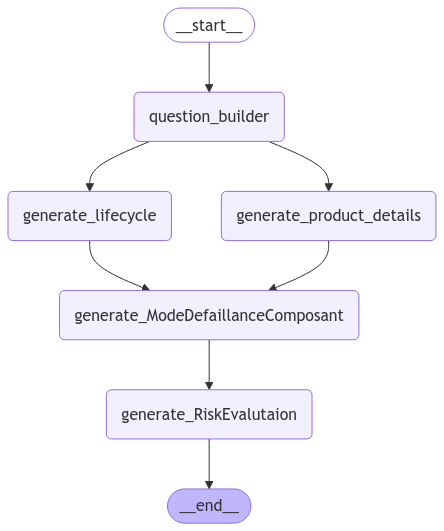

In [226]:


builder = StateGraph(SearchProductState)
builder.add_node("question_builder", question_builder)
builder.add_node("generate_lifecycle", generate_lifecycle)
builder.add_node("generate_product_details", generate_product_details)
builder.add_node("generate_ModeDefaillanceComposant", generate_ModeDefaillanceComposant)
builder.add_node("generate_RiskEvalutaion",generate_RiskEvalutaion)

builder.add_edge(START, "question_builder")
builder.add_edge("question_builder", "generate_lifecycle")
builder.add_edge("question_builder", "generate_product_details")

builder.add_edge("generate_lifecycle", "generate_ModeDefaillanceComposant")
builder.add_edge("generate_product_details", "generate_ModeDefaillanceComposant")
builder.add_edge("generate_ModeDefaillanceComposant", "generate_RiskEvalutaion")
builder.add_edge("generate_RiskEvalutaion", END)

memory = MemorySaver()
graph = builder.compile( checkpointer=memory)

# View
display(Image(graph.get_graph(xray=3).draw_mermaid_png()))

In [229]:
thread = {"configurable": {"thread_id": "1"}}

reference='MZT8-03VPS-KUB'
# Run the graph until the first interruption
for event in graph.stream({"reference":reference}, thread, stream_mode="values"):
    # Review
    print(event)

{'reference': 'MZT8-03VPS-KUB', 'lifecycle': LifeCycle(product_name='MZT8-03VPS-KUB', version=None, release_date='2024-04-22', mainstream_support_end='2029-04-22', extended_support_end=None, end_of_support='2029-04-22', end_of_life='2029-04-22', is_supported=True, replacement_product=None), 'product_details': ProductDetails(product_name='MZT8-03VPS-KUB Magnetic Cylinder Sensor', product_number='MZT8-03VPS-KUB', description='The SICK MZT8-03VPS-KUB is a magnetic cylinder sensor designed for T-slot applications. It features a PNP, normally open (NO) output, and operates with a DC 3-wire connection. The sensor comes with a 5-meter PUR cable and is suitable for use in environments requiring IP68/IP69K protection.', manufacturer='SICK', product_family='Magnetic Cylinder Sensors', datasheet_url='https://cdn.sick.com/media/pdf/4/54/654/dataSheet_MZT8-03VPS-KUB_1044470_en.pdf', power_requirements='10 to 30VDC', dimensions=None, weight=None, operating_temperature=None, humidity_range=None, ip_r

In [223]:
graph.get_state(thread).values

{'reference': 'SPC200-2AI-U',
 'lifecycle': LifeCycle(product_name='Festo SPC200', version=None, release_date='2001-09-01', mainstream_support_end='2014-04-01', extended_support_end=None, end_of_support='2014-04-01', end_of_life='2014-04-01', is_supported=False, replacement_product=None),
 'product_details': ProductDetails(product_name='Festo SPC200-2AI-U', product_number='SPC200-2AI-U', description='The Festo SPC200-2AI-U is an analogue input module designed for use with the SPC200 Smart Positioning Controller. It provides two differential inputs for controlling up to two axes with an analogue voltage signal (0-10V), allowing for precise positioning of actuators in industrial applications.', manufacturer='Festo', product_family='I/O Systems', datasheet_url='https://manualzz.com/doc/61912737/festo-spc200-2ai-u-brief-description', power_requirements=None, dimensions=None, weight=None, operating_temperature=None, humidity_range=None, ip_rating=None, performance_metrics=None, certificatio